In [15]:
# Importing working libraries
import os
import cv2
import urllib3
import imutils
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# Select your development environment
environment = "Google Colab" # "Google Colab", "Local"

# Loading depending on environment
lab4_path = ""
if environment == "Google Colab":
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  # Import from my google drive
  drive.mount('/content/drive')
  lab4_path = "/content/drive/MyDrive/Colab Notebooks/UAB Project/Computer Vision/UAB23-Computer-Vision-Labs/Lab 4"
else:
  lab4_path = "./"

# Load images path
path_images = os.path.join(lab4_path,"dataset")
path_images_train = os.path.join(path_images,"train")
path_images_test = os.path.join(path_images,"test")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Block 4. Feature detection, Image descriptors and BoVW

This lab explores the fundamental concepts of feature extraction and feature descriptors in computer vision. It delves into various feature detection techniques like Harris corner and LoG blob detectors, and descriptor methods like SIFT, SURF, and ORB. Additionally, the lab introduces the Bag of Visual Words model, demonstrating its application in image classification, particularly using a subset of the VOC dataset.

### Objectives:
1. **Implement Feature extraction methods**
  - **Implement Harris Corner Detector**: Understand and implement the Harris corner detection algorithm to identify corner features in images.
  - **Implement LoG Blob Detector**: Learn and apply the Laplacian of Gaussian method for blob detection in images.
2. **Implement Image feature descriptors** (Reusing part of the feature extraction code)
  - **Implement Normalized Color Histogram and Color Space Changes**: Explore color features by implementing normalized color histograms and understanding the impact of different color spaces.
  - **Use SIFT, SURF, and ORB**: Use these feature descriptors, analyze their strengths and weaknesses, and compare their performance.
3. **Provide a Pipeline for Bag of Words and Compute Results on Subset of VOC Dataset**: Develop a Bag of Visual Words model and test its efficacy in classifying images from a subset of the VOC dataset.

---

### Mandatory Questions:

1. Explain the principles behind corner detectors, specifically the Harris corner detection method. Why is it effective in identifying corners?
2. Discuss the main differences between edge detection and corner detection. Why are corners considered more robust features?
3. What are the limitations of the Harris corner detector in complex images?
4. Describe the Laplacian of Gaussian blob detector. How does it differ from edge detection?
5. Discuss the role of feature descriptors in object recognition.
6. Why are color histograms useful for image feature extraction? Describe the process of creating a normalized color histogram.
7. How does a change in color space affect feature extraction in images?
8. Explain the concepts of scale and rotation invariance in feature detection. For each algorithm (SIFT, SURF, and ORB), explain how they handle scale and rotation variations in images.
9. Compare SIFT, SURF, and ORB in terms of computational efficiency and accuracy.
10. What is the role of orientation assignment in the SIFT algorithm?
11. How does the ORB algorithm differ from SIFT and SURF in terms of feature matching?
12. How do feature descriptors contribute to the process of image stitching (for panorama images)?
13. Discuss the impact of varying lighting conditions on feature detection and description. How can these challenges be mitigated?
14. What are the key steps in constructing a Bag of Visual Words model? Explain each of them in detail.
15. In the context of the Bag of Visual Words model, explain the significance of feature quantization. Discuss on which steps it can be done and how it affects the results.


### Optional Deep Dive Questions:

1. Discuss the potential weaknesses of the LoG blob detector in real-world scenarios. Propose improvements.
2. Explore the potential of hybrid color spaces (combining properties of different color models) in improving the robustness of feature extraction for applications in varied lighting and environmental conditions.
3. Discuss the impact of varying image resolutions on the effectiveness of feature descriptors.
4. Discuss the limitations of current feature descriptors in handling occlusions and propose potential improvements.
5. Evaluate the performance of hybrid feature detectors that combine the properties of multiple algorithms (like SIFT and Harris). What are the potential benefits?
6. Analyze the role of feature extraction in content-based image retrieval systems. How do they impact the efficiency and accuracy of searches?
7. How might the Bag of Visual Words model be modified or extended to improve classification accuracy?
8. Consider the role of context in feature-based image classification. How might contextual information be incorporated into the Bag of Visual Words model?


### Exercise 1: Harris Corner Detector Implementation
**Objective**:

Implement the Harris Corner Detection algorithm to identify corner features in images.

**Guideline**:
- Load image.
- Implement the basic Harris Corner Detection algorithm.
- Apply the algorithm to the images and visualize the detected corners.
- Explore the impact of parameter changes on detection quality.
- (Optional) Implement the Harris-Laplace and the Harris-Affine improvments and compare the pros and cons of each version

**Expected Results**:
- A working Harris Corner Detection implementation.
- Visualization of corner detection in various images.

In [18]:
def harris_corner_detector(image, k=0.04, threshold=0.01):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)

    # Compute gradients using Sobel operators
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Compute elements of the Harris matrix
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy

    # Compute the sum of squared differences
    Sxx = cv2.GaussianBlur(Ixx, (3, 3), 0)
    Syy = cv2.GaussianBlur(Iyy, (3, 3), 0)
    Sxy = cv2.GaussianBlur(Ixy, (3, 3), 0)

    # Compute the determinant and trace of the Harris matrix
    det = (Sxx * Syy) - (Sxy ** 2)
    trace = Sxx + Syy

    # Compute the Harris response
    harris_response = det - k * (trace ** 2)

    # Threshold the response to identify corners
    corners = np.where(harris_response > threshold * harris_response.max())

    # Draw circles around the detected corners
    result = image.copy()
    result[corners] = [0, 0, 255]  # Red color for corners

    return result

# List of images
images_path = [
    os.path.join(path_images_train,"aquarium","sun_acjrhiyqadrbtovi.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aamlnkpomzzujqpa.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aashbnpnxflmstxu.jpg"),
    os.path.join(path_images_train,"kitchen","sun_afbibxsnpvkmvhxn.jpg"),
    os.path.join(path_images_train,"kitchen","sun_acgxyyrqtufcunpm.jpg"),
    os.path.join(path_images_train,"kitchen","sun_ahyafiyoyrzkifbh.jpg")
]

# Parameters variations
k_values = [0.02, 0.04, 0.06]
threshold_values = [0.005, 0.01, 0.015]

for image_path in images_path:
    # Load the image
    original_image = cv2.imread(image_path)

    # Display the results using Matplotlib for each parameter variation
    for k in k_values:
        for threshold in threshold_values:
            # Apply Harris Corner Detector (Your Implementation)
            result_image_your_impl = harris_corner_detector(original_image, k, threshold)

            # Apply Harris Corner Detector (OpenCV Implementation)
            gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
            gray = np.float32(gray)
            harris_response_cv = cv2.cornerHarris(gray, 2, 3, k)

            # Threshold the response to identify corners in OpenCV's implementation
            corners_cv = np.where(harris_response_cv > threshold * harris_response_cv.max())

            # Draw circles around the detected corners in OpenCV's implementation
            result_image_opencv_impl = original_image.copy()
            result_image_opencv_impl[corners_cv[0], corners_cv[1]] = [0, 255, 0]  # Correct way to mark corners

            # Display the results using Matplotlib
            plt.figure(figsize=(15, 6))

            plt.subplot(231)
            plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(232)
            plt.imshow(cv2.cvtColor(result_image_your_impl, cv2.COLOR_BGR2RGB))
            plt.title(f'Our Harris (k={k}, th={threshold})')
            plt.axis('off')

            plt.subplot(233)
            plt.imshow(cv2.cvtColor(result_image_opencv_impl, cv2.COLOR_BGR2RGB))
            plt.title(f'OpenCV Harris (k={k}, th={threshold})')
            plt.axis('off')

            plt.show()

Output hidden; open in https://colab.research.google.com to view.


### Exercise 2: LoG Blob Detector Implementation
**Objective**:

Develop and apply the LoG method for blob detection in images, understanding its application in feature extraction.

**Guideline**:
- Select diverse images for blob detection.
- Implement the LoG Blob Detector.
- Analyze the LoG method's effectiveness.
- Compare LoG with other blob detection methods.
- (Optional) Implement your own version of other methods (DoG, DoH, ...) or design your own

**Expected Results**:
- Documented LoG Blob Detector implementation.
- Comparative analysis of blob detection results.
- Evaluation of method effectiveness and limitations.


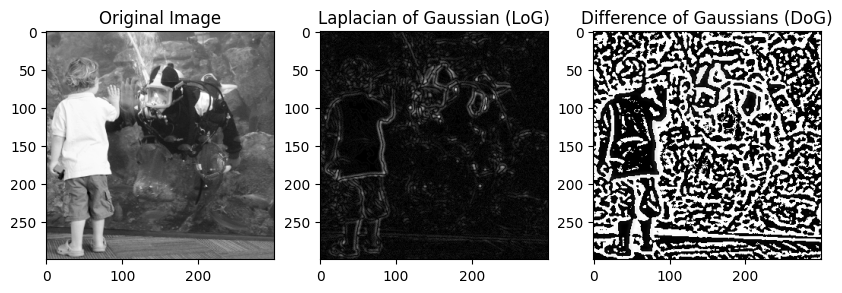

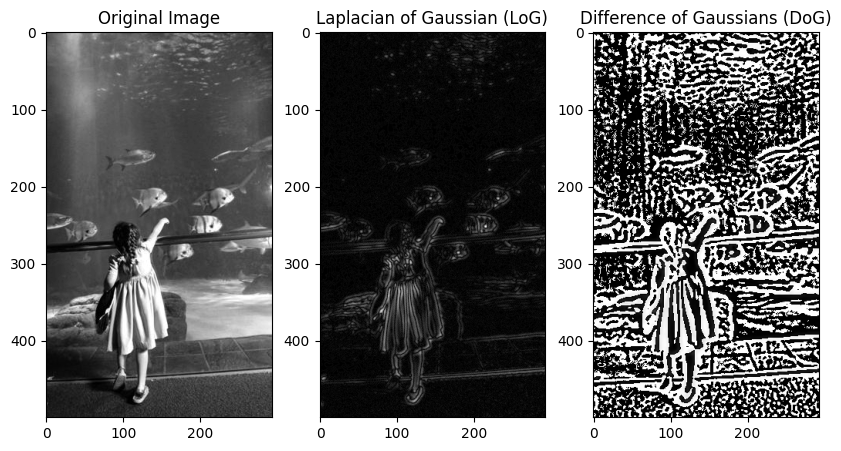

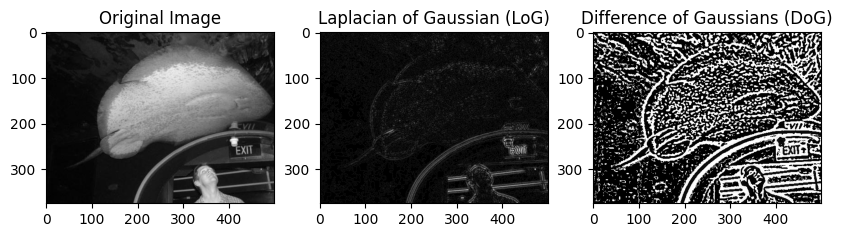

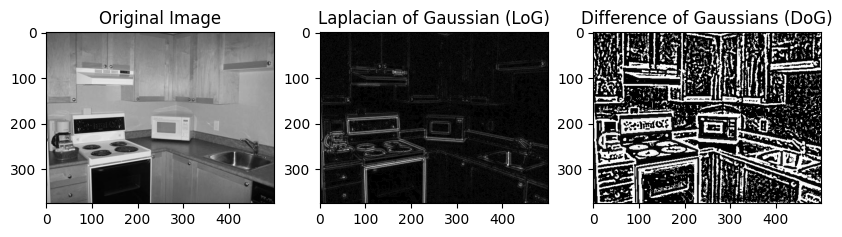

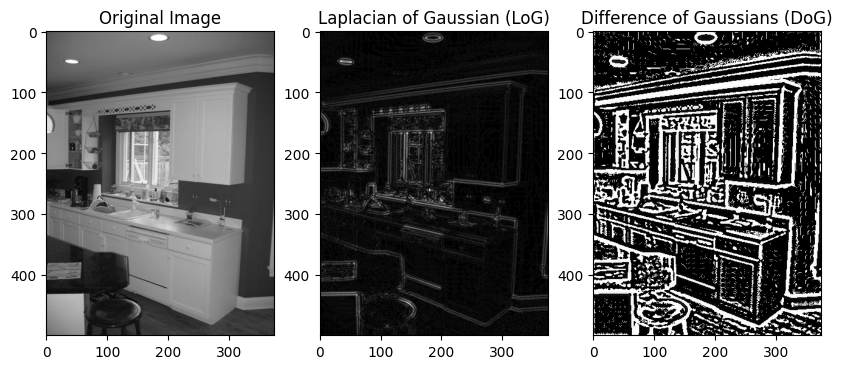

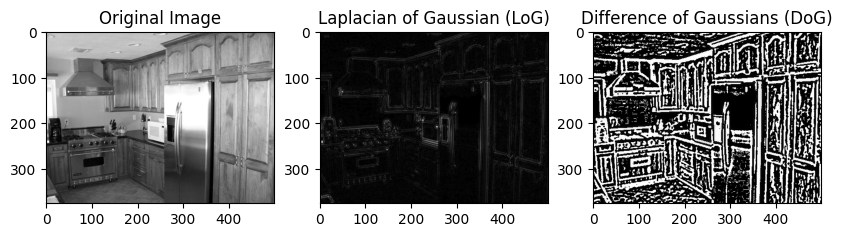

In [27]:
def log_blob_detector(image_path, sigma):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_blur = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma, sigmaY=sigma)
    img_log = cv2.Laplacian(img_blur, cv2.CV_64F)
    img_log_abs = np.absolute(img_log)
    return(img_log_abs)

def dog_blob_detector(image_path, sigma1, sigma2):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_blur1 = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma1, sigmaY=sigma1)
    img_blur2 = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma2, sigmaY=sigma2)
    img_dog = img_blur1 - img_blur2
    return(img_dog)

# List of images
images_path = [
    os.path.join(path_images_train,"aquarium","sun_acjrhiyqadrbtovi.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aamlnkpomzzujqpa.jpg"),
    os.path.join(path_images_train,"aquarium","sun_aashbnpnxflmstxu.jpg"),
    os.path.join(path_images_train,"kitchen","sun_afbibxsnpvkmvhxn.jpg"),
    os.path.join(path_images_train,"kitchen","sun_acgxyyrqtufcunpm.jpg"),
    os.path.join(path_images_train,"kitchen","sun_ahyafiyoyrzkifbh.jpg")
]

sigma_value = 1.5

for image_path in images_path:
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_log_blob = log_blob_detector(image_path, sigma_value)
    img_dog_blob = dog_blob_detector(image_path, sigma_value, sigma_value * 1.6)
    plt.figure(figsize=(10, 5))
    plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Original Image')
    plt.subplot(132), plt.imshow(img_log_blob, cmap='gray'), plt.title('Laplacian of Gaussian (LoG)')
    plt.subplot(133), plt.imshow(img_dog_blob, cmap='gray'), plt.title('Difference of Gaussians (DoG)')
    plt.show()


### Exercise 3: Normalized Color Histogram and Color Space Changes
**Objective**:
Implement normalized color histograms and explore color space transformations' impact on feature extraction.

**Guideline**:
- Implement normalized color histograms.
- Transform images into different color spaces and generate histograms.
- Analyze the impact of color space changes.

**Expected Results**:
- Color histograms in various spaces for a set of images.
- Comparative analysis on color space impact.
- Discussion on color in feature extraction and analysis.



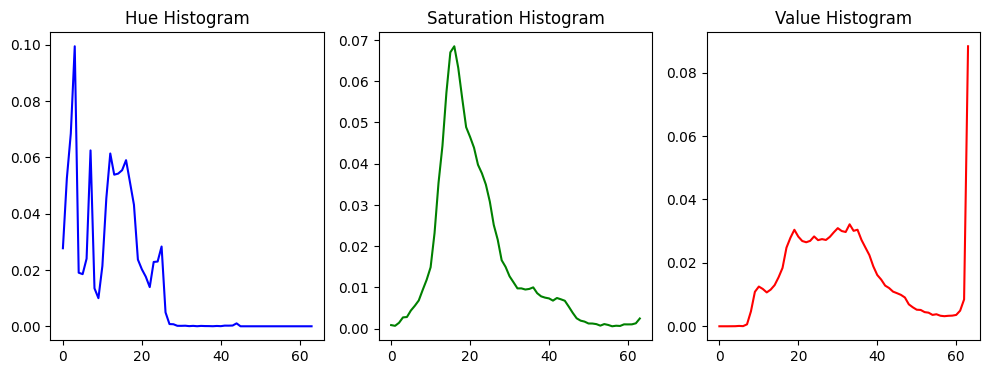

In [33]:
def normalize_histogram(hist):
    return hist / np.sum(hist)

def calculate_normalized_color_histogram(image, bins=64):
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Calculate the histogram for each channel (Hue, Saturation, Value)
    hist_hue = cv2.calcHist([hsv_image], [0], None, [bins], [0, 256])
    hist_saturation = cv2.calcHist([hsv_image], [1], None, [bins], [0, 256])
    hist_value = cv2.calcHist([hsv_image], [2], None, [bins], [0, 256])

    # Normalize the histograms
    hist_hue_normalized = normalize_histogram(hist_hue)
    hist_saturation_normalized = normalize_histogram(hist_saturation)
    hist_value_normalized = normalize_histogram(hist_value)

    return hist_hue_normalized, hist_saturation_normalized, hist_value_normalized

def plot_histograms(hist1, hist2, hist3, title1, title2, title3):
    plt.figure(figsize=(12, 4))

    plt.subplot(131)
    plt.plot(hist1, color='b')
    plt.title(title1)

    plt.subplot(132)
    plt.plot(hist2, color='g')
    plt.title(title2)

    plt.subplot(133)
    plt.plot(hist3, color='r')
    plt.title(title3)

    plt.show()

# Load an example image
image_path = os.path.join(path_images_train,"aquarium","sun_acjrhiyqadrbtovi.jpg")
original_image = cv2.imread(image_path)

# Calculate normalized color histograms
hist_hue, hist_saturation, hist_value = calculate_normalized_color_histogram(original_image)

# Plot the histograms
plot_histograms(hist_hue, hist_saturation, hist_value, 'Hue Histogram', 'Saturation Histogram', 'Value Histogram')

### Exercise 4: Implementation and Analysis of SIFT, SURF, and ORB
**Objective**:
Implement and analyze SIFT, SURF, and ORB feature descriptors (use opencv implementations), understanding their pros and cons.

**Guideline**:
- Select a diverse image dataset.
- Implement SIFT and ORB algorithms. (Since SURF is patented, is optionally in the comparions)
- Apply these methods to some images.

**Expected Results**:
- Implementations of SIFT, ORB (and SURF).
- Hyperparameter analysis of each algorithm.
- Comparision of the methods

### (Optional) Exercise 4.5: Implement other image descriptor methods (motion, shape, ...)


### Exercise 5: Bag of Visual Words Pipeline and VOC Dataset Analysis
**Objective**:
Develop a BoVW model and apply it to classify images from the VOC dataset, focusing on the BoVW approach.

**Guideline**:
- Load the VOC dataset.
- Implement the BoVW model.
- Apply the model to the dataset for classification.
- Evaluate the model's performance.

**Expected Results**:
- Implementation of the Bag of Visual Words model.
- Application of the model for image classification.
- Evaluation of the model's performance.

**Optional Enhancements**:
- Experiment with different clustering algorithms for codebook generation in the BoVW model.

### Step 1: Data Loading
- **Objective**: Load images from each class into a format suitable for processing.
- **Guide**: Use a library like OpenCV or PIL in Python to load images. Iterate over the folders, loading each image and storing it with its class label.

### Step 2: Feature Extraction
- **Objective**: Extract features from each image to represent its content.
- **Guide**: Apply a feature descriptor to each image. This transforms the image into a set of features. Examples can be SIFT, SURF, Color histogram, etc

### Step 3: Building the Vocabulary (Codebook)
- **Objective**: Create a vocabulary of visual words (features) that represents the dataset.
- **Guide**: Cluster the extracted features across all images using any clustering algorithm. Each cluster center is a visual word.

### Step 4: Feature Encoding
- **Objective**: Encode each image as a frequency histogram of visual words.
- **Guide**: For each image, count how many features fall into each cluster (visual word) and create a histogram.

### Step 5: Classifier Training
- **Objective**: Train a machine learning model to classify the images.
- **Guide**: Use the histograms as input features for a classifier. Any supervised classifier can be used (SVM, Random Forest, KNN, Neural nets, ...)

### Step 6: Model Evaluation
- **Objective**: Evaluate the performance of the classifier.
- **Guide**: Use a confusion matrix to visualize the performance and extract metrics.